### Render

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

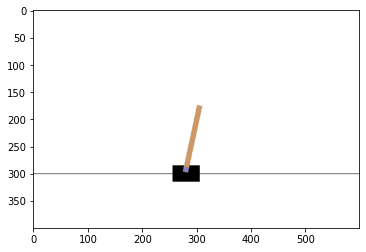

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

In [ ]:
!pip install roboschool==1.0.48 gym==0.15.4

     |████████████████████████████████| 44.9MB 150kB/s 
     |████████████████████████████████| 1.6MB 25.2MB/s 
     |████████████████████████████████| 1.0MB 31.5MB/s 
  Created wheel for gym: filename=gym-0.15.4-cp37-none-any.whl size=1648486 sha256=18dc0194814776e1513358bd25f4c77858c790a52b513e5b804e4571435275bd
  Stored in directory: /root/.cache/pip/wheels/e9/26/9b/8a1a6599a91077a938ac4348cc3d3ac84bfab0dbfddeb4c6e7
Successfully built gym
ERROR: tensorflow-probability 0.12.1 has requirement cloudpickle>=1.3, but you'll have cloudpickle 1.2.2 which is incompatible.
  Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
!git clone https://github.com/Stable-Baselines-Team/stable-baselines-tf2.git

In [ ]:
!pip install ./stable-baselines-tf2

In [ ]:
### The A2C algorithms are very less sample efficient, and hence is unsuitable for solving continous action space problems.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import functools
import operator
import gym
import roboschool
from multiprocessing_env import SubprocVecEnv

In [ ]:
### The pi_old is the poicy for the n-1 th iteration policy, when we calculate for n th iteration.
### The constraint is only applied for a particuar iteration for the batch updates.

In [ ]:
class PPO_continous_action:

  def __init__(self,env,env_name,num_of_env,env_max_steps=None):

    self.env=env
    self.state_dimension=env.observation_space.shape   ###PPO_continous_action_space Input state dimension
    self.no_of_action=env.action_space.shape[0]              ### No of actions
    self.no_of_env=num_of_env
    self.Actor=None      ### the learner
    self.Critic=None     ### Critic
    self.env=SubprocVecEnv([self.create_env(env_name,i,max_steps=env_max_steps) for i in range(self.no_of_env)])
    self.opt=tf.keras.optimizers.Adam(0.0003)
    self.steps_in_epi=512    ### Fixed number of steps in a episode
    self.iterations=5000         ### Number of epochs
    #self.log_std=tf.Variable(tf.zeros((1,self.no_of_action)))
    self.max_clip_value=2
    self.min_clip_value=-20
    self.epochs=10

  def create_env(self,env_id,rank=0,max_steps=None):
      seed=100
      def get_env():         #### The seed lets generate same sequence, and starting state is same and
      ### every time performance is same
        env=gym.make(env_id)
        if max_steps is not None:
          env._max_episode_steps=max_steps
        env.seed(seed+rank)
        return env
      return get_env
    ### Creates the multiple environments

  
  def get_actor(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the probability distribution of the actions.

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer_mu=tf.keras.layers.Dense(self.no_of_action,activation=None)(layer_3)
    output_layer_log_sigma=tf.keras.layers.Dense(self.no_of_action,activation=None)(layer_3)

    ### Predicts the peobability of all the actions on the state s, so the number of nodes in
    ### the final layer of model is equal to the number of actions 
    ### and we generate the mean action of the state so, we use a relu instead of softmax in case of discrete actions
    
    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer_mu,output_layer_log_sigma])
    
    return model
  
  def get_critic(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the estimate value function V(s)

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(1)(layer_3)  ### Predicts the Value function for that state.

    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    return model
  
  
  def action(self,s):
    

    mu,log_sigma=self.Actor(s)   
    action_prob=tfp.distributions.Normal(mu,tf.math.exp(tf.clip_by_value(log_sigma,self.min_clip_value,self.max_clip_value)))
    action= action_prob.sample()
    ### sampling an action from the obtained probability distributions for all the action
    return action.numpy()  ### Action returned as 1D tensor-> converting to scalar

  def prob(self,s,a):

    mu,log_sigma=self.Actor(s)
    ### again to be used in batch
    action_prob=tfp.distributions.Normal(mu,tf.math.exp(tf.clip_by_value(log_sigma,self.min_clip_value,self.max_clip_value)))
    ### takes in the states and the actions and returns the corresponding log probability 
    ### of the occurence of the taken action a on the state s
    ### log(P[a|s : w]) is obtained.
    return action_prob.log_prob(a)
  
  def get_value(self,state):

    value=self.Critic(state).numpy()
    return value

  def get_test_action(self,s):
    s=s.reshape(1,-1)
    mean_action,_=self.Actor(s)
    return mean_action.numpy()

  def actor_loss(self,log_old_probs,S,A,Adv,epsilon=0.2):
    
    log_new_probs=self.prob(S,A)  
    importance_ratio = tf.math.exp(tf.math.subtract(log_new_probs,log_old_probs))
    surr_1=tf.multiply(importance_ratio,Adv)
    surr_2=tf.multiply(tf.clip_by_value(importance_ratio,1-epsilon,1+epsilon),Adv)
    L_clip=-1*tf.reduce_mean(tf.reduce_min([surr_1,surr_2],axis=0))
    
    return L_clip

  def critic_loss(self,S,ret):
    L_vf= 0.5*tf.reduce_mean(tf.math.squared_difference(ret,self.Critic(S)))
    return L_vf
  
  def entropy(self,S):
    mu,log_sigma=self.Actor(S)
    dist=tfp.distributions.Normal(mu,tf.math.exp(tf.clip_by_value(log_sigma,self.min_clip_value,self.max_clip_value)))
    L_S=tf.reduce_mean(dist.entropy())
    return L_S
    ### Entropy induces exploration.
  
  def total_loss(self,old_probs,S,A,rets,Adv,c1=0.5,c2=0.001):
    act_loss=self.actor_loss(old_probs,S,A,Adv)
    crit_loss=self.critic_loss(S,rets)
    entropy_loss=self.entropy(S)

    total_loss=act_loss+c1*crit_loss-c2*entropy_loss
    return total_loss
  
  def train_on_batch(self,probs,s,a,adv,r):
    with tf.GradientTape() as t:
        loss=self.total_loss(probs,s,a,r,adv)
      ### Calculating loss
    grads=t.gradient(loss,self.Actor.trainable_variables+self.Critic.trainable_variables)

    self.opt.apply_gradients(zip(grads,self.Actor.trainable_variables+self.Critic.trainable_variables))
    #### Applying gradients.
    return 0
  
  def get_episodes(self):
    ### To sample raw walks in the environment
    states=[]
    actions=[]
    rewards=[]
    values=[]
    next_values=[]
    not_done=[]
    old_probs=[]
    

    done=False
    curr_state=self.env.reset()
    for _ in range(self.steps_in_epi):
      ### Recording fixed number of steps.
      acts=self.action(curr_state)
      next_state,reward,done,_=self.env.step(acts)
      ### Obtaining next step.
      value=self.get_value(curr_state)
      next_value=self.get_value(next_state)
      probs=self.prob(curr_state,acts)

      states.append(curr_state)
      actions.append(acts)
      rewards.append(reward)
      values.append(value.ravel())
      next_values.append(next_value.ravel())
      old_probs.append(probs)
      not_done.append(1-done)

      curr_state=next_state
      
      ### logging the essential required values for loss estimation

    return np.asarray(states).astype(np.float32),\
           np.asarray(actions).astype(np.float32),\
           np.asarray(rewards).astype(np.float32),\
           np.asarray(values).astype(np.float32),\
           np.asarray(next_values).astype(np.float32),\
           np.asarray(old_probs).astype(np.float32),\
           np.asarray(not_done).astype(np.float32)  ### All logs returned

  def get_gae(self,next_values,values,rewards,not_dones,gamma=0.99,lam=0.95):
    
    gae=0
    returns=[]
    ### Calculating GAE according to formulation.
    for step in reversed(range(len(rewards))):
      TD_error_delta = rewards[step] + gamma * next_values[step] * not_dones[step] - values[step]
      gae = TD_error_delta + gamma * lam * not_dones[step] * gae
      ret = gae + values[step]
      returns.insert(0,ret)
    
    return np.array(returns)
    
  def functools_reduce_iconcat(self,a):
    return np.array(functools.reduce(operator.iconcat, a, []),dtype="float32")
    ### Converts stacks of the environment returns to 1D vectors

 
  def test_play(self):
    ### Testing results for current weights.
    overall=0
    for _ in range(5):
      curr_states=self.env.reset()
      curr_state=curr_states[0]
      total_reward=0
      done=[False]*self.no_of_env
      while not done[0]:
        a=self.get_test_action(curr_state)
        acts=[a[0]]
        for z in range(self.no_of_env-1):
          acts.append(np.array([0]*self.no_of_action,dtype="float32"))
        next_state,reward,done,_=(self.env.step(np.array(acts)))
        total_reward+=reward[0]
        curr_state=next_state[0]

      overall+=total_reward
    return overall/5
  
  def train(self,batch_size=128):
    ### Training
    self.Actor=self.get_actor()
    self.Critic=self.get_critic()

    for i in range(self.iterations):
      ### For each epoch
      s,a,R,v,Nv,op,Nd=self.get_episodes()
      
      ret=self.get_gae(Nv,v,R,Nd)

      ret=self.functools_reduce_iconcat(ret).reshape(-1,1)
      s=self.functools_reduce_iconcat(s)
      a=self.functools_reduce_iconcat(a)
      v=self.functools_reduce_iconcat(v).reshape(-1,1)
      op=self.functools_reduce_iconcat(op)

      adv=ret-v
      adv=adv.astype('float32')
      adv=(adv-adv.mean())/(adv.std())
      total_no_of_samples=len(s)


      dataset=tf.data.Dataset.from_tensor_slices((op,s,a,adv,ret)).shuffle(total_no_of_samples).repeat(self.epochs).batch(batch_size,drop_remainder=True)         

      for (prob_sample,s_sample,a_sample,adv_sample,r_sample) in dataset:
        self.train_on_batch(prob_sample,s_sample,a_sample,adv_sample,r_sample)
      
      if i%10==0:
        score=self.test_play()
        print(f"On Iteration {i} scores: {score}")

  


In [ ]:
env = gym.make('RoboschoolInvertedPendulum-v1')

In [ ]:
agent=PPO_continous_action(env,'RoboschoolInvertedPendulum-v1',8)

In [ ]:
agent.train()

On Iteration 0 scores: 162.2
On Iteration 10 scores: 1000.0
